## State-free Non-reversible VAMPNets (SNV)
This notebook demonstrates the use of the non-reversible functionality of SRVs. We use the example of a one-dimensional four well potential and, instead of estimating the eigenfunctions of the transfer operator under the assumption of reversibility, we calculate the left and right spectral components treating without assuming reversibility.

In [ ]:
%matplotlib inline 
import numpy as np 
import scipy
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 

In [ ]:
from hde import HDE

## Four well potential 
Code in this section is adapted from MSMbuilder (https://github.com/msmbuilder/msmbuilder) to eliminate dependencies.

In [3]:
DIFFUSION_CONST = 1e3
DT = 1e-3
DT_SQRT_2D = DT * np.sqrt(2 * DIFFUSION_CONST)
QUADWELL_GRAD_POTENTIAL = lambda x: 4 * (
    8 * x ** 7 - 128 * x * np.exp(-80 * x ** 2) - \
    32 * (x - 0.5) * np.exp(-80 * (x - 0.5) ** 2) - 40 * (x + 0.5) * np.exp(
        -40 * (x + 0.5) ** 2))
QUADWELL_POTENTIAL = lambda x: 4 * (
    x ** 8 + 0.8 * np.exp(-80 * x ** 2) + 0.2 * np.exp(
    -80 * (x - 0.5) ** 2) + \
    0.5 * np.exp(-40 * (x + 0.5) ** 2))

In [4]:
def _reflect_boundary_conditions(x, min, max):
    if x > max:
        return 2 * max - x
    if x < min:
        return 2 * min - x
    return x

In [5]:
def _propagate1d(x0, n_steps, grad_potential, random, bc_min=None, bc_max=None,
                 verbose=True):
    n_steps = int(n_steps)

    if bc_min is None and bc_max is None:
        bc = lambda x: x
    else:
        bc = lambda x: _reflect_boundary_conditions(x, bc_min, bc_max)

    rand = random.randn(n_steps)
    x = np.zeros(n_steps + 1)
    x[0] = x0
    for i in range(n_steps):
        x_i_plus_1 = x[i] - DT * grad_potential(x[i]) + DT_SQRT_2D * rand[i]
        x[i + 1] = bc(x_i_plus_1)

    return x

In [6]:
def _normalize_eigensystem(u, lv, rv):
    # first normalize the stationary distribution separately
    lv[:, 0] = lv[:, 0] / np.sum(lv[:, 0])

    for i in range(1, lv.shape[1]):
        # the remaining left eigenvectors to satisfy
        # <\phi_i, \phi_i>_{\mu^{-1}} = 1
        lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))

    for i in range(rv.shape[1]):
        # the right eigenvectors to satisfy <\phi_i, \psi_j> = \delta_{ij}
        rv[:, i] = rv[:, i] / np.dot(lv[:, i], rv[:, i])

    return u, lv, rv

In [7]:
def _solve_msm_eigensystem(transmat, k):
    u, lv, rv = scipy.linalg.eig(transmat, left=True, right=True)
    order = np.argsort(-np.real(u))
    u = np.real_if_close(u[order[:k]])
    lv = np.real_if_close(lv[:, order[:k]])
    rv = np.real_if_close(rv[:, order[:k]])
    return _normalize_eigensystem(u, lv, rv)

In [8]:
def _brownian_transmat(n_grid, lag_time, grad_potential, xmin, xmax, reflect_bc):
    ONE_OVER_SQRT_2PI = 1.0 / (np.sqrt(2 * np.pi))
    normalpdf = lambda x: ONE_OVER_SQRT_2PI * np.exp(-0.5 * (x * x))

    grid = np.linspace(xmin, xmax, n_grid)
    width = grid[1] - grid[0]
    transmat = np.zeros((n_grid, n_grid))
    for i, x_i in enumerate(grid):
        if reflect_bc:
            for offset in range(-(n_grid - 1), n_grid):
                x_j = x_i + (offset * width)
                j = _reflect_boundary_conditions(i + offset, 0, n_grid - 1)

                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)
        else:
            for j, x_j in enumerate(grid):
                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)

        transmat[i, :] = transmat[i, :] / np.sum(transmat[i, :])
    transmat = np.linalg.matrix_power(transmat, lag_time)
    return transmat

In [9]:
def _brownian_eigs(n_grid, lag_time, grad_potential, xmin, xmax, reflect_bc):
    """Analytic eigenvalues/eigenvectors for 1D Brownian dynamics
    """
    transmat = _brownian_transmat(n_grid, lag_time, grad_potential, xmin, xmax, reflect_bc)
    u, _, rv = _solve_msm_eigensystem(transmat, k=len(transmat) - 1)
    return u, rv

## Visualize potential

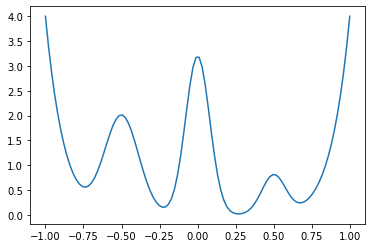

In [10]:
x_pot = np.linspace(-1.0, 1.0, 100)
y_pot = QUADWELL_POTENTIAL(x_pot)
plt.plot(x_pot, y_pot)

## Generate trajectory

In [11]:
traj = _propagate1d(0, 5e6, QUADWELL_GRAD_POTENTIAL, random=np.random, verbose=False)
traj = traj.reshape(-1, 1).astype(np.float32)

### Visualize trajectory density and free energy

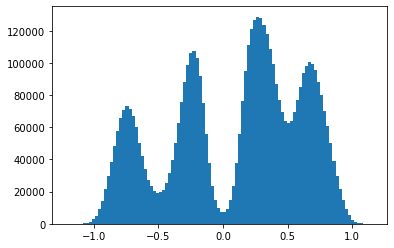

In [12]:
bin_counts, bin_locs, _ = plt.hist(traj, bins=100)

Text(0, 0.5, 'F (kbT)')

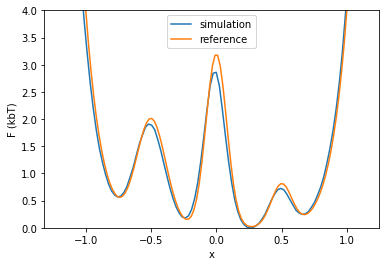

In [13]:
plt.plot(bin_locs[:-1], -np.log(bin_counts) - np.min(-np.log(bin_counts)))
plt.plot(x_pot, y_pot)
plt.ylim([0, 4])
plt.legend(['simulation', 'reference'])
plt.xlabel('x')
plt.ylabel('F (kbT)')

## Train SNV
Here we scale the trajectory then train the SNV. Note the use of `reversible=False` flag.

In [14]:
lag = 100

In [15]:
traj_scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
traj_train = traj_scaler.fit_transform(traj)

In [17]:
hde = HDE(
    1, 
    n_components=3, 
    lag_time=lag, 
    n_epochs=200, 
    batch_size=1000000,
    learning_rate=0.01,
    validation_split=0.00,
    batch_normalization=True,
    reversible=False
)

In [ ]:
hde.fit(traj_train);

## Compare results with reference solution

In [20]:
u, v = _brownian_eigs(100, lag, QUADWELL_GRAD_POTENTIAL, -1.0, 1.0, reflect_bc=False)
v = np.real(v)

### Eigenvalue comparison

In [21]:
print('Reference eigenvalues: ' + ', '.join([f'{x:0.5f}' for x in u[1:4]]))
print('Estimated eigenvalues: ' + ', '.join([f'{x:0.5f}' for x in hde.eigenvalues_]))

Reference eigenvalues: 0.88807, 0.44977, 0.21003
Estimated eigenvalues: 0.88592, 0.45170, 0.20955


### Comparison of singular components

In [22]:
x_grid = np.linspace(-1, 1, 100).reshape(-1,1)
xs_grid = traj_scaler.fit_transform(x_grid)

In [23]:
z_grid_left = hde.transform(xs_grid, side='left')
z_grid_right = hde.transform(xs_grid, side='right')

Make sure signs of coordinates are consistent for plotting.

In [24]:
z_grid_left = z_grid_left*np.sign(z_grid_left[0])
z_grid_right = z_grid_right*np.sign(z_grid_right[0])
v = v*np.sign(v[0])

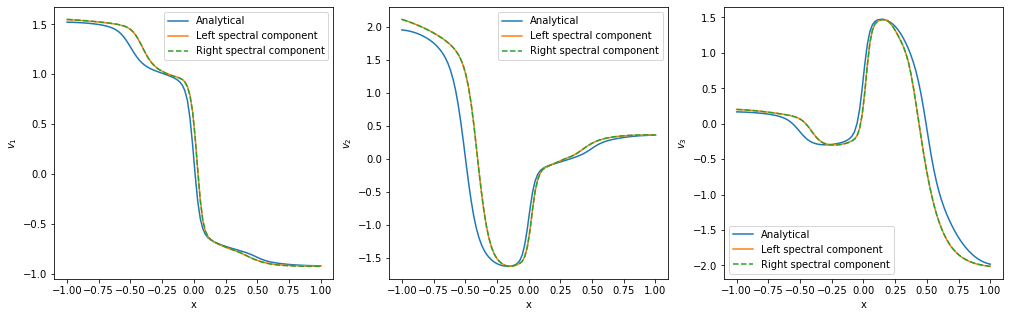

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, ax in enumerate(axes): 
    ax.plot(x_grid, v[:,i+1])
    ax.plot(x_grid, z_grid_left[:,i])
    ax.plot(x_grid, z_grid_right[:,i], '--')
    ax.set_xlabel('x')
    ax.set_ylabel(f'$v_{i+1}$')
    ax.legend(['Analytical', 'Left spectral component', 'Right spectral component'])